In [33]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pytensor.tensor as pt
from pytensor import function
from pytensor.printing import Print
import seaborn as sns
import jax
import blackjax
import numpyro
import pymc.sampling.jax as pmjax
import tensorflow as tf

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [34]:

az.style.use("arviz-darkgrid")

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [35]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')

In [ ]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')


# Number of samples.
n = 450
# Generate data.
data_df = generate_data(n=n)
# Plot. 
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y', data=data_df, color=sns_c[0], label='y', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data', xlabel='t', ylabel='');

### Train Test Split

In [ ]:
x = data_df['t'].values.reshape(n, 1)
y = data_df['y'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

### Model

In [38]:
# jax.default_backend()
# %env XLA_PYTHON_CLIENT_PREALLOCATE = false

In [39]:
numpyro.set_host_device_count(4)
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))
    # Linear trend.
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    # Define gaussian process.
    gp = gp_1 + gp_2 + gp_3
    3
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), sigma=sigma)
    # Sample.
    #trace = pm.sample(init='jitter+adapt_diag_grad', draws=500, cores=4, chains=2)
    trace =  pm.sample(nuts_sampler="numpyro", progressbar=True, draws=100)
    #trace = pm.sampling_jax.sample_numpyro_nuts(draws=1000, chains=4, chain_method='parallel', progress_bar= True, postprocessing_backend="cpu") 
    #trace = pm.sample(nuts_sampler="blackjax")
    #trace = pm.sample(nuts_sampler="nutpie")
    # pmjax.sample_numpyro_nuts(1000)
    # trace = pmjax.sample_numpyro_nuts(draws=1000, chains=2, chain_method = "parallel", postprocessing_backend="cpu")
    # trace = pmjax.sample_numpyro_nuts(draws=1000, chains=4, chain_method = "vectorized", postprocessing_backend="gpu") 
    # trace = pmjax.sample_numpyro_nuts(draws=1000, chains=2, chain_method = "parallel", postprocessing_backend="gpu") 
    

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1100/1100 [04:11<00:00,  4.38it/s, 31 steps of size 1.69e-01. acc. prob=0.93] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


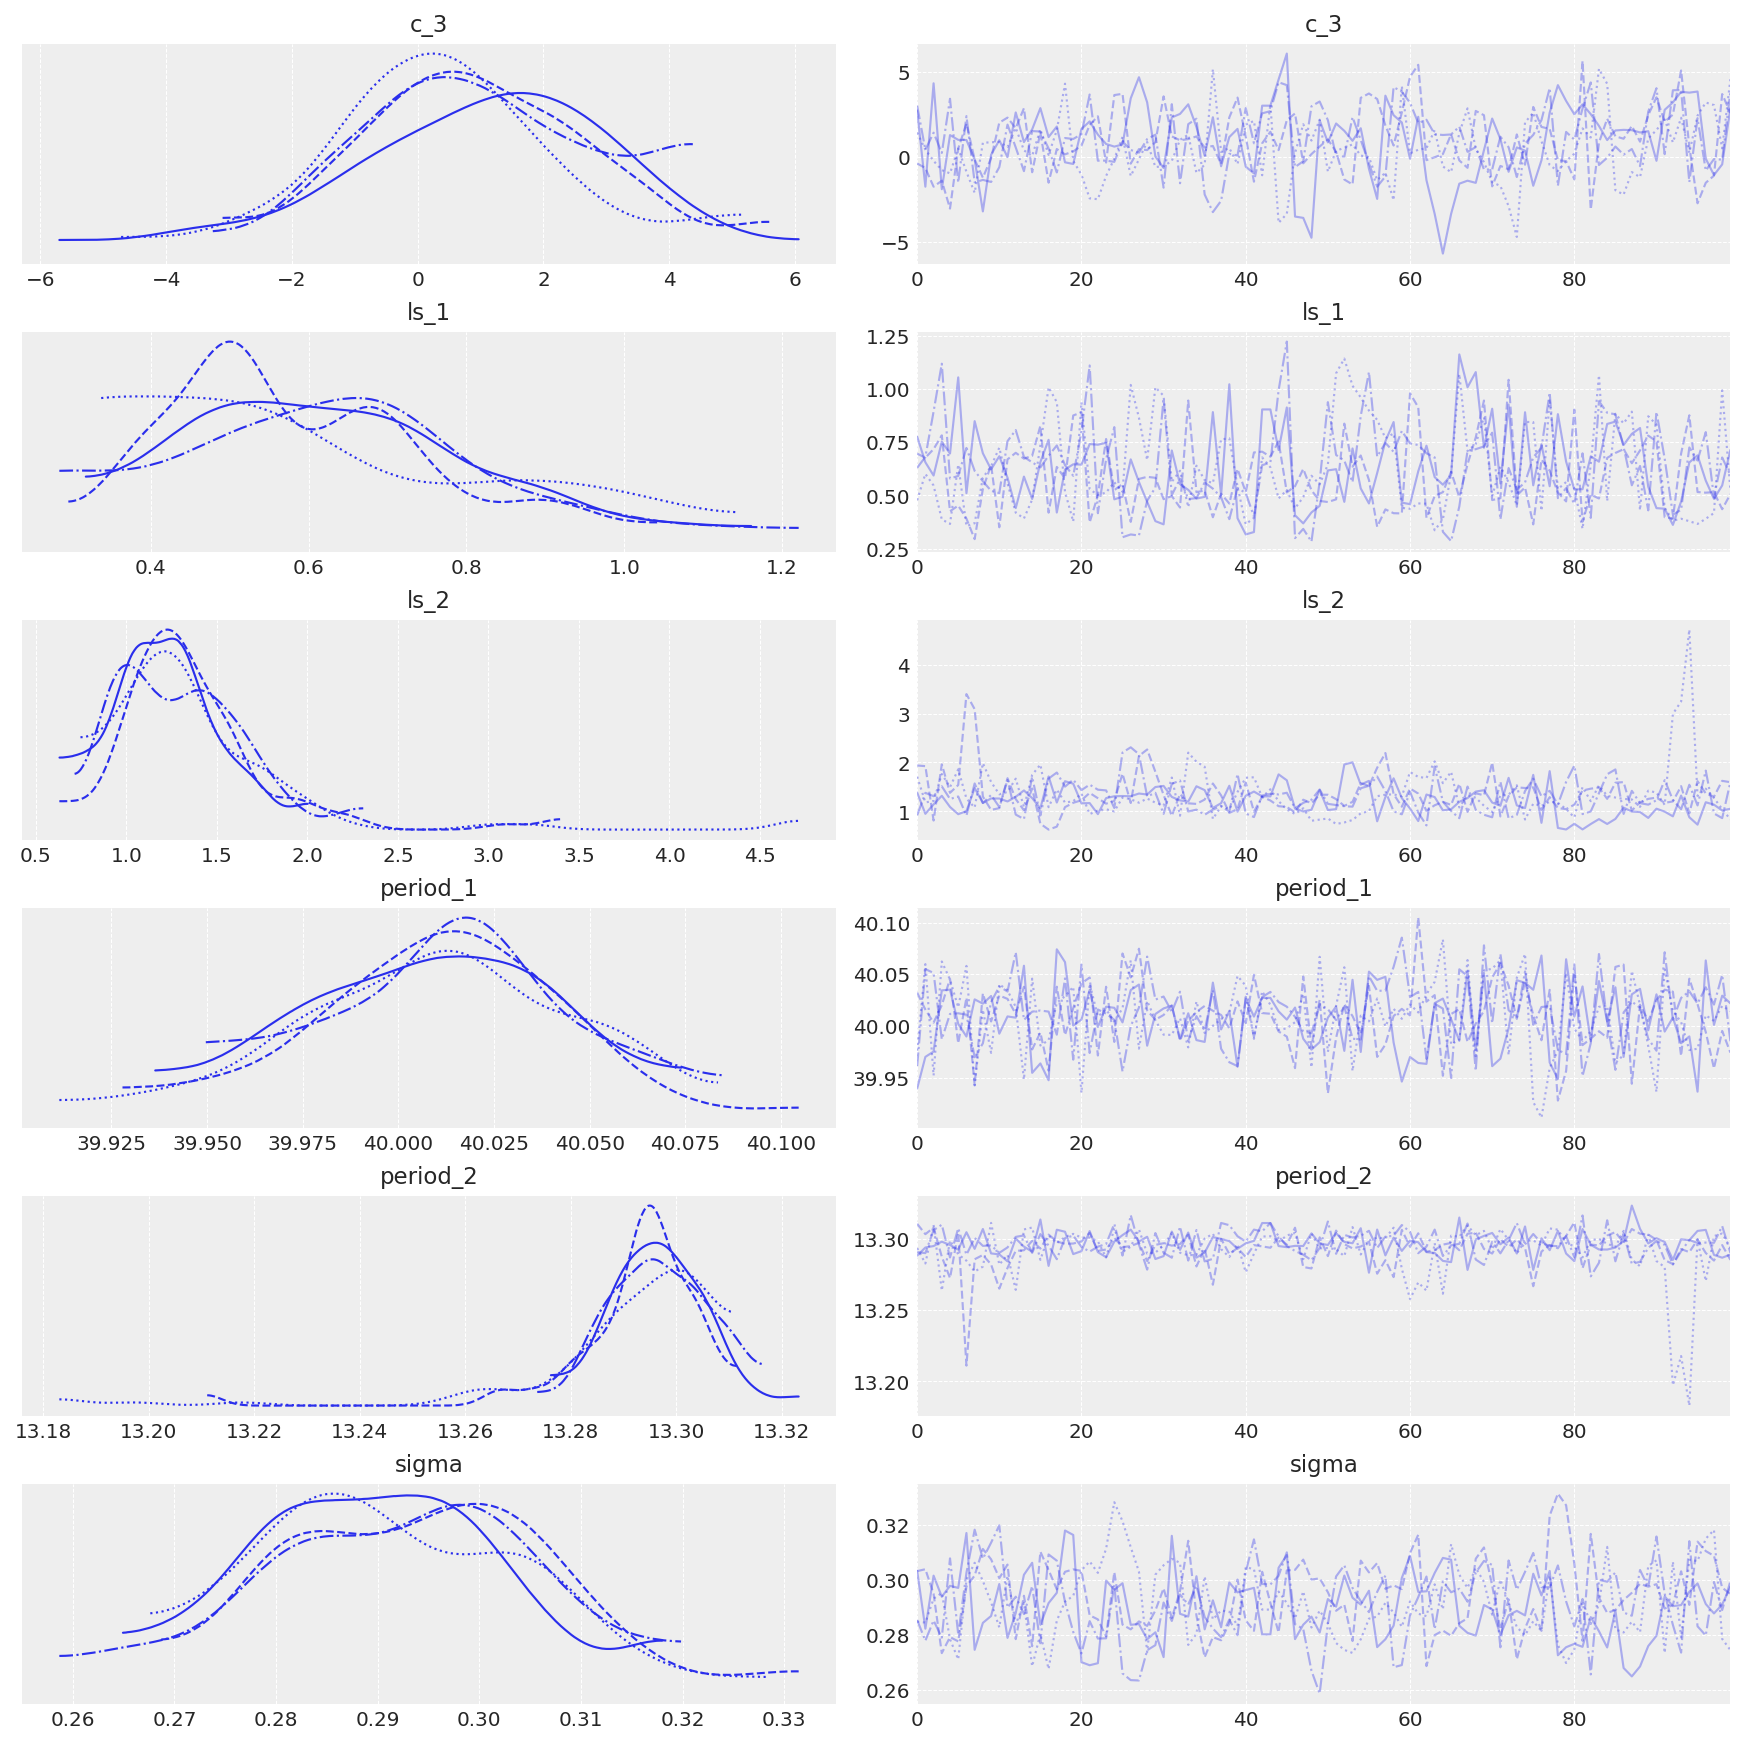

In [40]:
# Plot parameters posterior distribution.
az.plot_trace(trace);

In [41]:
# Get model summary.
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c_3,0.815,1.921,-2.601,4.561,0.121,0.087,256.0,231.0,1.00
ls_1,0.624,0.190,0.283,0.960,0.012,0.009,245.0,259.0,1.02
ls_2,1.310,0.407,0.729,1.962,0.031,0.022,146.0,124.0,1.02
period_1,40.010,0.033,39.952,40.071,0.001,0.001,483.0,364.0,1.01
period_2,13.294,0.014,13.276,13.312,0.001,0.001,307.0,208.0,1.01
sigma,0.292,0.013,0.268,0.315,0.001,0.001,190.0,213.0,1.01


In [42]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [45]:
with model:
    
    x_train_conditional = gp.conditional('x_train_conditional', x_train)
    y_train_pred_samples = pm.sample_posterior_predictive(trace, var_names=["x_train_conditional"])

    x_test_conditional = gp.conditional('x_test_conditional', x_test)
    y_test_pred_samples = pm.sample_posterior_predictive(trace, var_names=["x_test_conditional"])

Sampling: [x_train_conditional]


Output()

Sampling: [x_test_conditional]


Output()

In [46]:
with model:
    y_train_pred_samples = pm.sample_posterior_predictive(trace, var_names=["x_train_conditional"])

Sampling: [x_train_conditional]


Output()

In [48]:
f_pred = (y_train_pred_samples.posterior_predictive.stack(samples=("chain", "draw"))['x_train_conditional'].values)

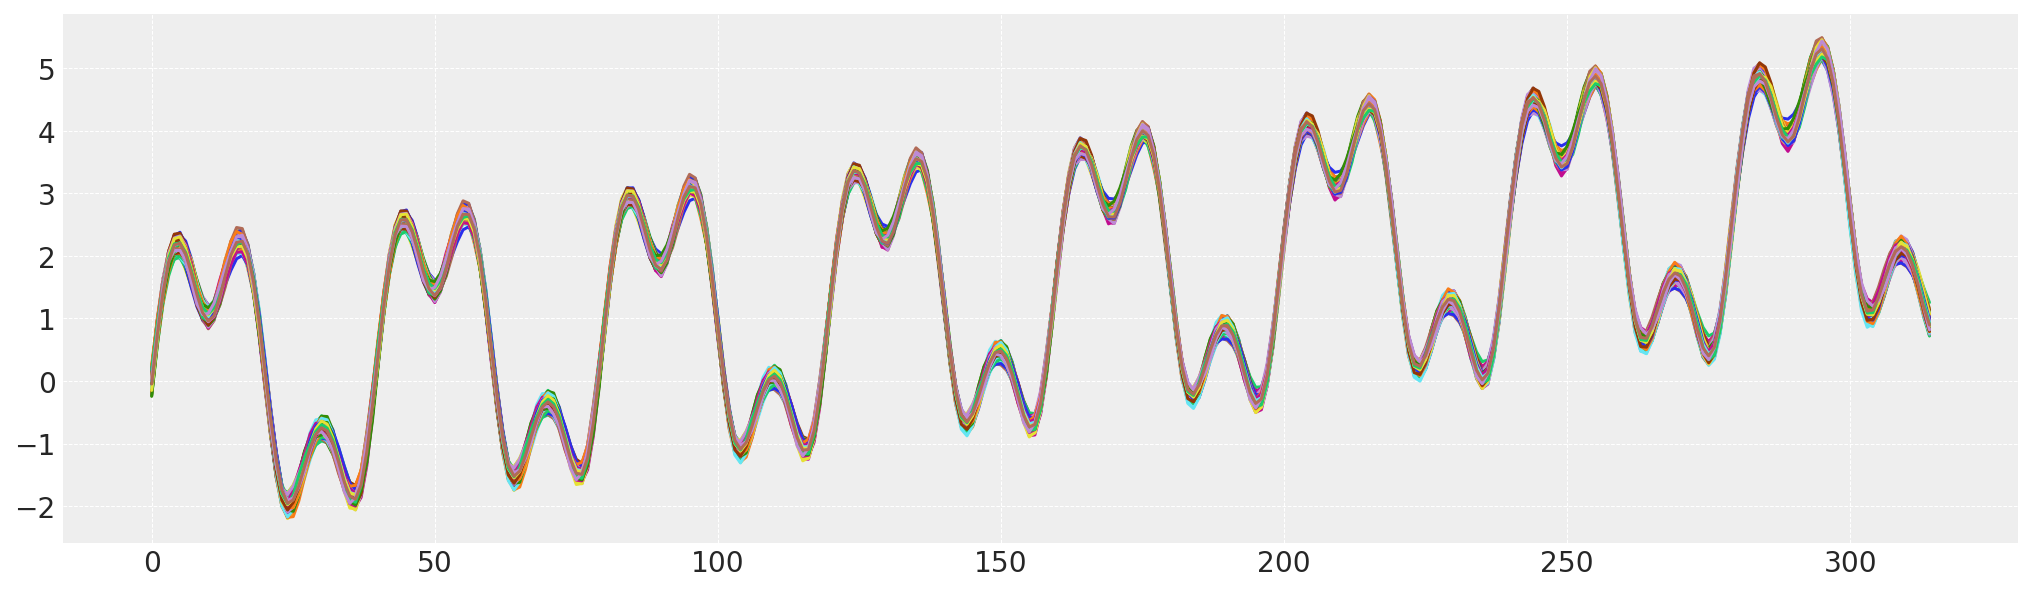

In [50]:
plt.plot(f_pred);

In [ ]:
with model:
    
    x_train_conditional2 = gp.conditional('x_train_conditional2', x_train)
    y_train_pred_samples = pm.sample_posterior_predictive(trace, var_names=["x_train_conditional2"])

    x_test_conditional2 = gp.conditional('x_test_conditional2', x_test)
    y_test_pred_samples = pm.sample_posterior_predictive(trace, var_names=["x_test_conditional2"])

In [ ]:
#y_train_pred_samples['x_train_conditional2_dim_2']
y_train_pred_samples

In [ ]:
# # Train
y_train_pred_samples_mean = y_train_pred_samples["x_train_conditional2"].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# # Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='');